In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from conformal_prediction import CP, calc_coverage
from preprocess_data import recode_variables_NHANES,recode_variables_LOOK_AHEAD, split_train_cal_test
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import os

from sklearn.preprocessing import StandardScaler

In [3]:
plots_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/plots'
results_folder = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/results'

In [4]:
f_path = '/Users/carlharris/Documents/AIEM/Diabetes/waist_circumference/data.csv'
NHANES_df = pd.read_csv(f_path, na_values="None")
NHANES_df = recode_variables_NHANES(NHANES_df)

In [5]:
# df.drop(df[df['Female'] == 1].index, inplace=True)
NHANES_df.dropna(inplace=True)


GENDER = 'MALE'
if GENDER == 'FEMALE':
    NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 1]
else:
    NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 0]
    

ed_dummies = ['ED_LESS_HS', 'ED_HS_GED', 'ED_SOME_COLL_AA', 'ED_COLL_ABOVE', 'ED_OTHR_DK']
race_dummies = ['HISPANIC', 'WHITE', 'BLACK', 'OTHER_MIXED']

# GENDER = 'MALE'
# if GENDER == 'FEMALE':
#     NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 1]
# else:
#     NHANES_df = NHANES_df[NHANES_df['FEMALE'] == 0]
    
# X = NHANES_df[[ 'AGE', 'WEIGHT', 'HEIGHT', 'BMI'] + race_dummies + ed_dummies]
X = NHANES_df[[ 'AGE', 'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]

outcome = 'WAIST'
y = NHANES_df[[outcome]]
y = y[outcome].astype(float)

In [6]:
from sklearn.linear_model import LinearRegression

NHANES_X, NHANES_y = split_train_cal_test(X, y, trn_prop=0.5, cal_prop=0.25)

alpha = 0.05
reg = CP(NHANES_X['train'], NHANES_X['cal'], NHANES_y['train'], NHANES_y['cal'], alpha=alpha, regressor="QR")
# reg.hyperparam_search(n_iter=100)
# reg.train()

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from xgboost import XGBRegressor, plot_importance 

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(NHANES_X['train'], NHANES_y['train'], test_size=0.2, random_state=42) 
# Create an XGBoost regressor 
xgb = XGBRegressor(random_state=42) 
# Hyperparameter tuning using GridSearchCV 
param_grid = { 
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 4, 5], 
    'learning_rate': [0.1, 0.01, 0.001] 
} 

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='r2', cv=10) 
grid_search.fit(X_train, y_train) 

# Get the best estimator 
best_xgb = grid_search.best_estimator_ 

# Train the model on the entire training set 
best_xgb.fit(X_train, y_train) 

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)

# Calculate the r2
r2 = best_xgb.score(X_test, y_test)
print('r2 = {}'.format(r2))


r2 = 0.9277125286617914


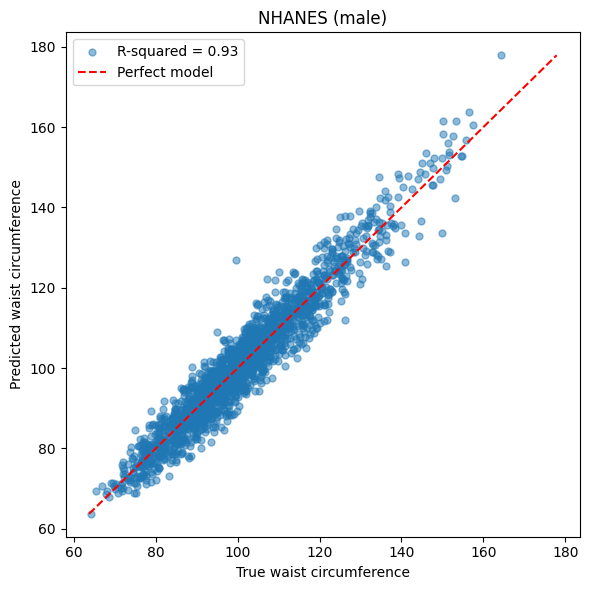

In [8]:
# Plot the scatter plot and line of best fit 
plt.figure(figsize=(6, 6)) 
plt.scatter(y_pred, y_test, label=f'R-squared = {r2:.2f}', alpha=0.5, s=25) 
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect model') 
plt.xlabel("True waist circumference") 
plt.ylabel("Predicted waist circumference") 
if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "NH_XGBoost_pred_actual_{gender}.pdf".format(gender=GENDER))
    if GENDER == "MALE":
        plt.title("NHANES (male)")
    else:
        plt.title("NHANES (female)")
else:
    img_path = os.path.join(plots_folder, "NH_XGBoost_pred_actual.pdf")
    plt.title("NHANES")
plt.legend() 

plt.tight_layout()

# Save the plot
plt.savefig(img_path, dpi=300)
plt.show() 

In [9]:
import shap

# compute the SHAP values for the linear model
background = shap.maskers.Independent(X, max_samples=25)
explainer = shap.Explainer(best_xgb.predict, background)
shap_values = explainer(X)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 19081it [04:11, 73.17it/s]                           


In [10]:
label_mappings = {
    "WEIGHT": "Weight (kg)",
    "HEIGHT": "Height (cm)",
    "AGE": "Age",
    "FEMALE": "Female",
    "HISPANIC": "Hispanic",
    "WHITE": "White",
    "BLACK": "Black",
    "OTHER_MIXED": "Other/mixed",
    "ED_LESS_HS": "< HS",
    "ED_HS_GED": "HS/GED",
    "ED_SOME_COLL_AA": "< B.A./AA",
    "ED_COLL_ABOVE": "College +",
    "ED_OTHR_DK": "Ed. other/DK"
}

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


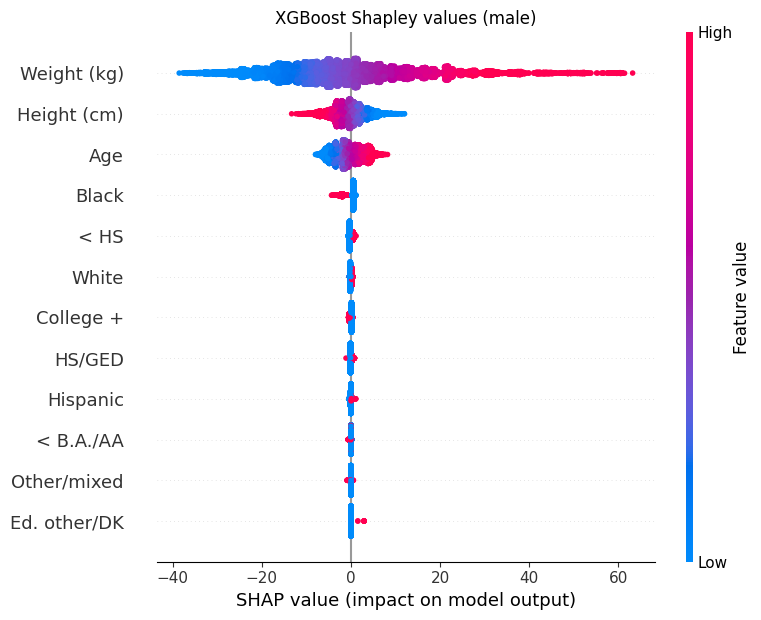

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4)) 

shap.plots.beeswarm(shap_values, max_display=13, show=False)
ax = plt.gca()  # get current axes

if GENDER == "MALE":
    ax.set_title('XGBoost Shapley values (male)')
else:
    ax.set_title('XGBoost Shapley values (female)')

y_labels = ax.get_yticklabels()

# Create a new list of labels based on your mapping.
new_labels = []
for label in y_labels:
    # Get the text of the current label
    text = label.get_text()
    
    # Replace the label text with the new text from your mapping, if it exists
    new_text = label_mappings.get(text, text)
    new_labels.append(new_text)

# Set the new labels
ax.set_yticklabels(new_labels)

# Because we've potentially changed the layout, we might need to re-adjust
plt.tight_layout()

img_path = os.path.join(plots_folder, "NH_shapley_{gender}.pdf".format(gender = GENDER))

# Save the plot
plt.savefig(img_path, dpi=300)

plt.show()

In [12]:
f_path = "/Users/carlharris/Documents/AIEM/Diabetes/LOOK AHEAD/Data/Baseline/Analysis_Data/baseline_combined.csv"
df = pd.read_csv(f_path)
df = recode_variables_LOOK_AHEAD(df)
df.dropna(inplace=True)

if GENDER == 'FEMALE':
    df = df[df['FEMALE'] == 1]
else:
    df = df[df['FEMALE'] == 0]
        

X = df[[ 'AGE',   'WEIGHT', 'HEIGHT'] + race_dummies + ed_dummies]
outcome = 'WAIST'
y = df[[outcome]]
y = y[outcome].astype(float)

LH_X, LH_y = split_train_cal_test(X, y, trn_prop=0.01, cal_prop=0.5)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

r2 = 0.7763103923297354


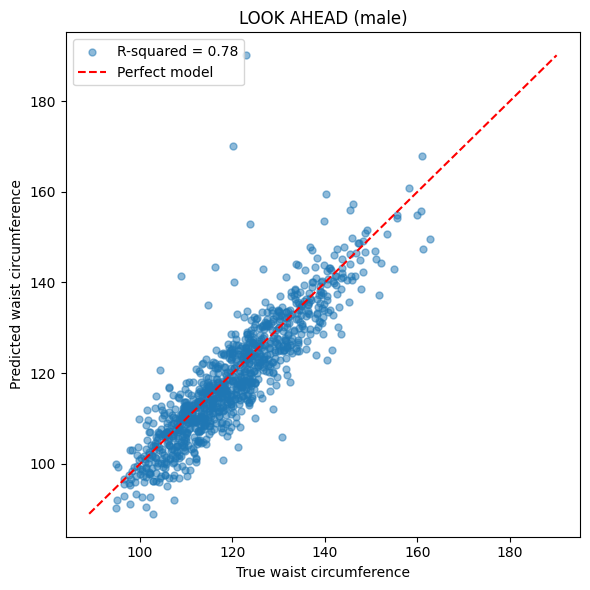

In [13]:
# Plot the scatter plot and line of best fit 
y_test = LH_y['test']
y_pred = best_xgb.predict(LH_X['test'])

# Calculate the r2
r2 = best_xgb.score(LH_X['test'], LH_y['test'])
print('r2 = {}'.format(r2))

plt.figure(figsize=(6, 6)) 
plt.scatter(y_pred, y_test, label=f'R-squared = {r2:.2f}', alpha=0.5, s=25) 
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect model') 
plt.xlabel("True waist circumference") 
plt.ylabel("Predicted waist circumference") 
if GENDER is not None:
    # Img path with gender
    img_path = os.path.join(plots_folder, "LH_XGBoost_pred_actual_{gender}.pdf".format(gender=GENDER))
    if GENDER == "MALE":
        plt.title("LOOK AHEAD (male)")
    else:
        plt.title("LOOK AHEAD (female)")
else:
    img_path = os.path.join(plots_folder, "LH_XGBoost_pred_actual.pdf")
    plt.title("LOOK AHEAD")
plt.legend() 

plt.tight_layout()

# Save the plot
plt.savefig(img_path, dpi=300)
plt.show() 